# import

In [1]:
import os
import pickle

import torch                                       # pytorch本体
import torch.nn as nn                              # ニューラルネットを構成する際の基本的なモジュールが入っている

import torch_radon as tr


import numpy as np
from PIL import Image                              # 画像を取り扱うために使用
import matplotlib.pyplot as plt                    # 画像のサンプル表示のために使用

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# dataのロードとdataloarderの作成

torch.Size([557, 371, 371])


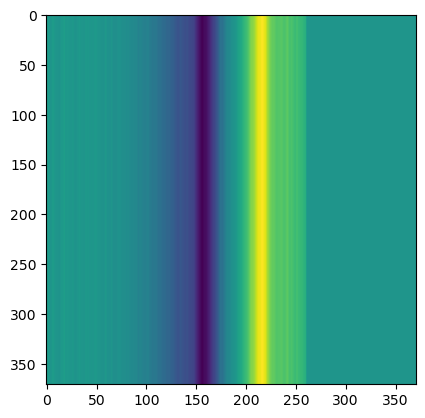

In [2]:
#ファイルのロード
sinogram_path="sinogram/sinogram_2410.npy"
sinogram=np.load(sinogram_path,allow_pickle=True)
sinogram_tensor=torch.FloatTensor(sinogram).permute(0, 2, 1).to(device)#tensor型に直す
print(sinogram_tensor.shape)
plt.imshow(sinogram_tensor[100,:,:].cpu())

In [3]:
#daaloarderの作成
batch_size=600 #ミニバッチのサイズを指定
target_dataloarder=torch.utils.data.DataLoader(sinogram_tensor.to(device),batch_size=batch_size,shuffle=False)#シャッフルは切っておく
predict_dataloarder=torch.utils.data.DataLoader(torch.zeros_like(sinogram_tensor),batch_size=batch_size,shuffle=False)#シャッフルは切っておく

dataloarders_dict={"target":target_dataloarder,"predict":predict_dataloarder}

# モデルとかの定義

In [4]:
# #radon変換のangleに代入するよう
# def create_cyclic_array(size):
#     # 0から359までの数値を含む配列を作成
#     array = np.arange(size) % 360
#     return array

# # 例えば、1000要素の配列を作成
# size = 371
# cyclic_array = create_cyclic_array(size)*np.pi/180

# print(len(cyclic_array))

# # 0から360までの値を含むndarrayを作成
# array = np.arange(0, 371)*np.pi/180
# print(array)

# define measuring angles
angles = np.linspace(0, np.pi, 3658, endpoint=False)
print(angles)

[0.         0.0084679  0.01693581 0.02540371 0.03387162 0.04233952
 0.05080743 0.05927533 0.06774324 0.07621114 0.08467905 0.09314695
 0.10161486 0.11008276 0.11855067 0.12701857 0.13548648 0.14395438
 0.15242229 0.16089019 0.16935809 0.177826   0.1862939  0.19476181
 0.20322971 0.21169762 0.22016552 0.22863343 0.23710133 0.24556924
 0.25403714 0.26250505 0.27097295 0.27944086 0.28790876 0.29637667
 0.30484457 0.31331247 0.32178038 0.33024828 0.33871619 0.34718409
 0.355652   0.3641199  0.37258781 0.38105571 0.38952362 0.39799152
 0.40645943 0.41492733 0.42339524 0.43186314 0.44033105 0.44879895
 0.45726686 0.46573476 0.47420266 0.48267057 0.49113847 0.49960638
 0.50807428 0.51654219 0.52501009 0.533478   0.5419459  0.55041381
 0.55888171 0.56734962 0.57581752 0.58428543 0.59275333 0.60122124
 0.60968914 0.61815705 0.62662495 0.63509285 0.64356076 0.65202866
 0.66049657 0.66896447 0.67743238 0.68590028 0.69436819 0.70283609
 0.711304   0.7197719  0.72823981 0.73670771 0.74517562 0.7536

In [5]:
#モデル

class ART(nn.Module):
    def __init__(self,sinogram,angles):
        super(ART, self).__init__()  # これを追加
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.sinogram=sinogram #[N,Size,Angle]
        from torch_radon import Radon,Radon
        #ラドン変換の関数の初期化
        self.radon_func=Radon(resolution=self.sinogram.shape[1], angles=angles, det_count=- 1, det_spacing=1.0, clip_to_circle=False)
    
    #ラドン変換の関数の定義
    def A(self,tomography):
        return self.radon_func.forward(tomography)
    def AT(self,sinogram):
        return self.radon_func.backprojection(sinogram)


# ループの関数
def trainer(model, dataloaders_dict, eps=1e-7):
    predict_dataloader = dataloaders_dict["predict"]
    target_dataloader = dataloaders_dict["target"]

    predicted_list=[]

    for predict_batch, target_batch in zip(predict_dataloader, target_dataloader):
        #データの準備
        predict_batch = predict_batch.to(model.device)
        target_batch = target_batch.to(model.device)

        iter = 0
        ATA = model.AT(model.A(torch.ones_like(predict_batch)))
        ave_loss = torch.inf  # 無限大の代わりに torch.inf を使用

        # 最初の損失の計算
        loss = torch.divide(model.AT(target_batch - model.A(predict_batch)), ATA)
        ave_loss = torch.max(torch.abs(loss)).item()

        while ave_loss > eps:
            predict_batch = predict_batch + loss  # 予測を更新
            ave_loss = torch.max(torch.abs(loss)).item()
            print(f'Iteration: {iter}, Loss: {ave_loss}') 
            iter += 1

            # 損失の再計算
            loss = torch.divide(model.AT(target_batch - model.A(predict_batch)), ATA)
            
        predicted_list.append(np.array(predict_batch.cpu()))
        
    return np.array(predicted_list)[0]

In [6]:
model=ART(sinogram,angles).to(device)
predicted_array=trainer(model,dataloarders_dict,eps=1e-7)

Iteration: 0, Loss: 2.740138370427303e-06
Iteration: 1, Loss: 2.053590378636727e-06
Iteration: 2, Loss: 1.8367625216342276e-06
Iteration: 3, Loss: 1.734326019686705e-06
Iteration: 4, Loss: 1.6400098274971242e-06
Iteration: 5, Loss: 1.5528694348176941e-06
Iteration: 6, Loss: 1.472267626922985e-06
Iteration: 7, Loss: 1.3977072512716404e-06
Iteration: 8, Loss: 1.3288002946865163e-06
Iteration: 9, Loss: 1.2652302530113957e-06
Iteration: 10, Loss: 1.2066889212292153e-06
Iteration: 11, Loss: 1.1528021559570334e-06
Iteration: 12, Loss: 1.1030091400243691e-06
Iteration: 13, Loss: 1.0568079460426816e-06
Iteration: 14, Loss: 1.013951418826764e-06
Iteration: 15, Loss: 9.747042213348323e-07
Iteration: 16, Loss: 9.381239465255931e-07
Iteration: 17, Loss: 9.080057452592882e-07
Iteration: 18, Loss: 8.810170584183652e-07
Iteration: 19, Loss: 8.550535426365968e-07
Iteration: 20, Loss: 8.300787044390745e-07
Iteration: 21, Loss: 8.060572440626856e-07
Iteration: 22, Loss: 7.82954145961412e-07
Iteration: 2

(557, 371, 371)


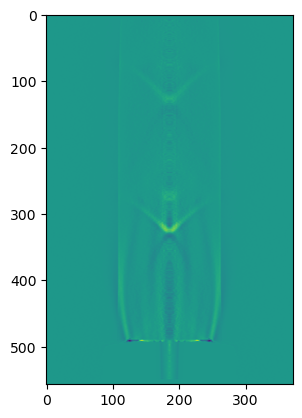

In [8]:
print(predicted_array.shape)
plt.imshow(predicted_array[:,180,:])
np.save("reconstructed/reconstructed.npy",predicted_array)